# 1D linearized shallow-water equation with wind stress


In [1]:
cd(@__DIR__)
using Pkg; Pkg.activate(".")
#Pkg.instantiate()  # Uncomment if needed for reproducibility
using OrdinaryDiffEq, ComponentArrays, JLD2, Plots, Statistics, Random, ProgressMeter, StatsBase, BSON

  Activating project at `~/Desktop/Deltares/Final Report Code/Model-2`


In [2]:
const SEED = rand(UInt)
Random.seed!(SEED); println("Using seed = $SEED")

# Input Data Generation Parameters
init_state = "flat"        # flat or bump or small_bump
wind_name = "periodic"     # piecewise or periodic or multi-frequency or AR(2) ( or zero or constant )
hours = 6                  # simulation time 
bias_factor = 1.1          # true wind multiplicative bias
wind_seed = 236            # seed for wind forcing generation 
folder = "data"            # folder to save data

@show init_state, wind_name, hours, bias_factor, wind_seed
nothing

Using seed = 9740792973392719357
(init_state, wind_name, hours, bias_factor, wind_seed) = ("flat", "periodic", 6, 1.1, 236)


### Setup

In [3]:
# Load model helpers
include("model_1d_surge_wave.jl") 
include("wind_forcing_functions.jl") 

# Define plot colors
colors = palette(:bluegreenyellow)[1:6]
cur_colors = theme_palette(:auto)

In [4]:
const DEBUG = true     # set to false to hide prints
const use_gpu = false  # set to true to use GPU if available

function debug(msg, override::Bool=DEBUG)
    if override
        println(msg)
    end
end

to_device(x) = x
if use_gpu
    try
        using CUDA
        println("CUDA is available. Using GPU.")
        CUDA.seed!(SEED)
        to_device(x) = gpu(x)
    catch e
        println("CUDA.jl not found or error loading it. Using CPU. Error: $e")
    end
else
    println("Using CPU.")
end

Using CPU.


In [5]:
# utils functions
function constant_func(t, value=0.0)
    return value
end

function run_model(f::Wave1DSurge_cpu, x0, t_start, t_end; saveat=nothing)
    prob = ODEProblem(f, x0, (t_start, t_end))
    @time sol = isnothing(saveat) ? solve(prob, Tsit5()) : solve(prob, Tsit5(), saveat=saveat)
    return sol
end

run_model (generic function with 1 method)

### Simulation Framework

In [6]:
# Spatial resolution
nx = 200   # number of grid points

# Time domain
t_start = 0.0
t_end = hours * 3600.0   # hours
dt_output = 60.0         # sample every minute
times = collect(t_start:dt_output:t_end)

# Spatial domain
L = 100.0e3      
dx = L / nx       
grid_u = collect(0.0:dx:L)               # cell edges (velocity grid)
grid_h = collect(dx/2:dx:(L - dx/2))     # cell centers (height grid)

# Physical constants
rho = 1000.0  # density 
g = 9.81      # gravitational acceleration 
W = 100.0     # channel width 
C = 60.0      # friction coefficient (or Chezy constant)

# Bathymetry (depth profile)
D_min = 10.0; D_max = 30.0  
D_edges = [0.3, 0.7] .* L       
D_widths = [0.05, 0.05] .* L   
D = depth_profile(grid_u, D_min, D_max, D_edges, D_widths)
D_centered = 0.5 .* (D[1:end-1] .+ D[2:end])

# Boundary conditions (closed boundaries)
q_left(t) = constant_func(t, 0.0)
q_right(t) = constant_func(t, 0.0) 

# Forcing parameters 
amplitude = 1.0
period = 8 * 3600.0

nothing

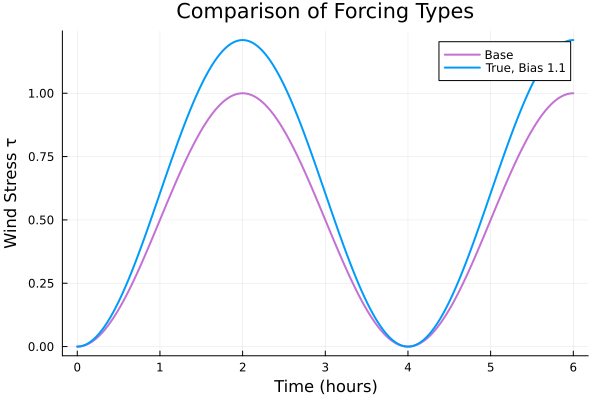

In [7]:
# Wind forcing additional data for functions 
avg_duration = 3600.0
noise_level = 0.2
coeffs = [0.8, 0.15]
sigma = 0.2
periods = [24 * 3600, 12 * 3600, 8 * 3600]
weights = [0.5, 0.3, 0.2]

if wind_name == "AR(2)"
    # Autoregressive process of order 2
    tau_nominal = make_tau_ar(amplitude=amplitude, coeffs=coeffs, sigma=sigma, seed=wind_seed)
    tau_true = make_tau_ar(amplitude=(amplitude * bias_factor), coeffs=coeffs, sigma=sigma, seed=wind_seed)

elseif wind_name == "piecewise"
    # Piecewise constant forcing with noise
    tau_nominal = make_tau_piecewise(amplitude=amplitude, avg_duration=avg_duration, noise_level=noise_level, seed=wind_seed) 
    tau_true = make_tau_piecewise(amplitude=(amplitude * bias_factor), avg_duration=avg_duration, noise_level=0.3, seed=wind_seed)

elseif wind_name == "zero"
    # No wind forcing
    tau_nominal = make_tau_zero() 
    tau_true = make_tau_zero() 

elseif wind_name == "constant"
    # Constant wind stress
    tau_nominal = make_tau_constant(amplitude=amplitude)
    tau_true = make_tau_constant(amplitude=(amplitude * bias_factor))

elseif wind_name == "periodic"
    # Single-frequency periodic forcing
    tau_nominal = make_tau_periodic(amplitude, period)
    tau_true = make_tau_periodic((amplitude * bias_factor), period)

elseif wind_name == "multi-frequency" 
    # Multi-frequency forcing with weighted components
    tau_nominal = make_tau_multifreq(amplitude=amplitude, periods=periods, weights=weights, seed=wind_seed)
    tau_true = make_tau_multifreq(amplitude=(amplitude * bias_factor), periods=periods, weights=weights, seed=wind_seed)
else 
    # Default fallback: periodic forcing
    wind_name == "periodic"
    tau_nominal = make_tau_periodic(amplitude, period)
    tau_true = make_tau_periodic((amplitude * bias_factor), period)
end

p = compare_forcings(Dict("Base" => tau_nominal, "True, Bias 1.1" => tau_true), times)
#savefig(p, "report_plots/wind_stress_bias_comparison.png")
display(p)

In [8]:
# Two model structs with different wind forcing
f_nominal = Wave1DSurge_cpu(g, D, L, W, dx, nx, rho, C, tau_nominal, q_left, q_right)
f_true = Wave1DSurge_cpu(g, D, L, W, dx, nx, rho, C, tau_true, q_left, q_right)

# Spatial grid setup
x_h = grid_h
x_u = grid_u
x = ComponentVector(h = x_h, u = x_u) # combined

# Initial state   (f; h0, w, c, u0)  ->  h0 = bump height, w = bump width, c = bump center, u0 = velocity bump
if init_state == "flat"
    # Flat start
    x0 = initial_state_bump(f_nominal, 0.0, 0.0, 0.0, 0.0)
elseif init_state == "bump"
    # Height bump with velocity bump
    x0 = initial_state_bump(f_nominal, 0.25, 0.05, 0.3, 0.0)
elseif init_state == "small_bump"
    # Smaller bump
    x0 = initial_state_bump(f_nominal, 0.05, 0.05, 0.3, 0.0)
else
    # Fallback to flat 
    x0 = initial_state_bump(f_nominal, 0.0, 0.0, 0.0, 0.0)
    init_state = "flat"
end

nothing

#### Initial State Visuals

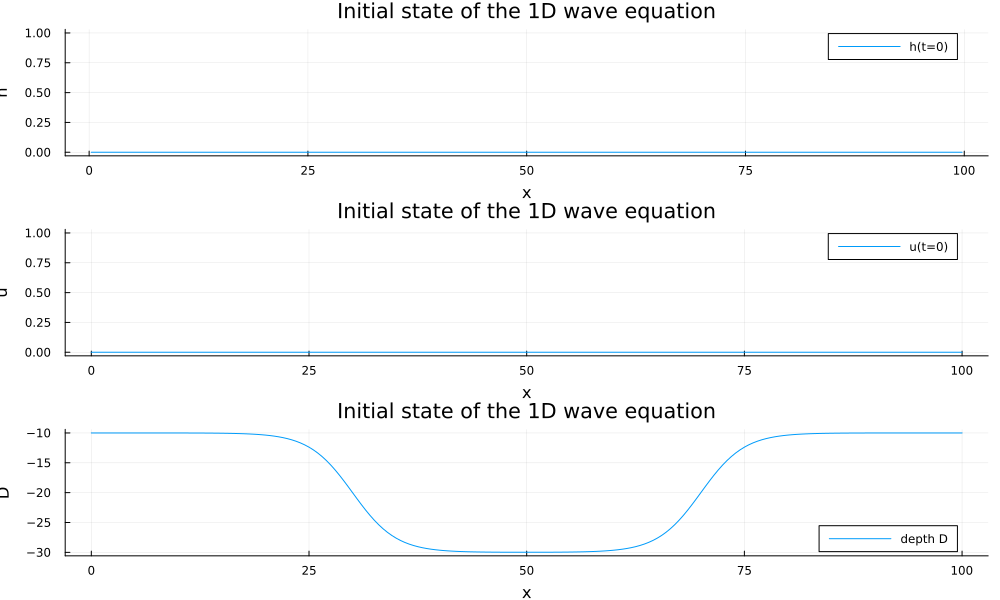

In [9]:
# Plot the initial state
p1 = plot(1e-3 * x_h, x0.h, label="h(t=0)", xlabel="x", ylabel="h", color=cur_colors[1])
p2 = plot(1e-3 * x_u, x0.u, label="u(t=0)", xlabel="x", ylabel="u", color=cur_colors[1])
p3 = plot(1e-3 * x_u, -D, label="depth D", xlabel="x", ylabel="D")
plot(p1, p2, p3, layout=(3, 1), size=(1000, 600), title="Initial state of the 1D wave equation")

size(dx_dt.u) = (201,)


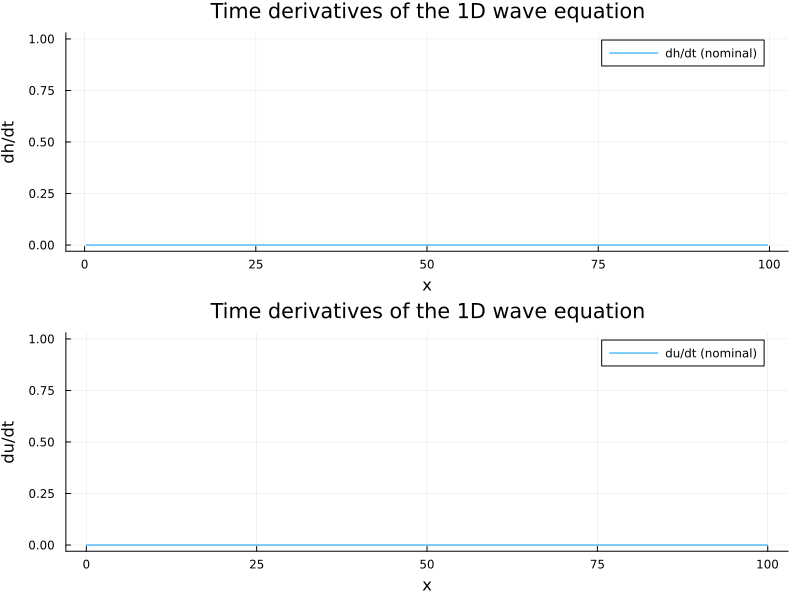

In [10]:
# Check model components 
dx_dt = similar(x0)

f_nominal(dx_dt, x0, f_nominal, times[1])
@show size(dx_dt.u)

p1 = plot(1e-3 * x_h, dx_dt.h, label="dh/dt (nominal)", xlabel="x", ylabel="dh/dt")
p2 = plot(1e-3 * x_u, dx_dt.u, label="du/dt (nominal)", xlabel="x", ylabel="du/dt")
plot(p1, p2, layout=(2, 1), size=(800, 600), title="Time derivatives of the 1D wave equation")


#### Numerical Simulation 


In [11]:
# Define station indices for measurements 
station_idxs = collect(1:nx)  
n_stations = length(station_idxs)

# Define coordinates for the stations
x_h_stations = x_h[station_idxs]  
x_u_stations = x_u[station_idxs] 

# Extract station water levels 
function run_model_and_extract(f::Wave1DSurge_cpu, x0, times, station_idxs)
    prob = ODEProblem(f, x0, (times[1], times[end]))
    #sol = solve(prob, Tsit5(), saveat=times)
    sol = solve(prob, KenCarp4(), saveat=times, reltol=1e-8, abstol=1e-10)
    #sol = solve(prob, Rodas5(), saveat=times, reltol=1e-8, abstol=1e-10)

    Y = zeros(length(times), length(station_idxs))
    for (i, t) in enumerate(times)
        Y[i, :] = sol(t).h[station_idxs]
    end
    
    return sol, Y
end

nothing

In [12]:
# Generate 'true' data (observations from the true model)
debug("Running true model to generate observations...")
sol_true, Y_true = run_model_and_extract(f_true, x0, times, station_idxs)

# Generate surrogate training data 
debug("Running nominal model to build surrogate training data...")
sol_nominal, Y_nominal = run_model_and_extract(f_nominal, x0, times, station_idxs)

nothing

Running true model to generate observations...
Running nominal model to build surrogate training data...


In [ ]:
# Save parameters and data for training surrogate model
total = length(sol_true.t)
params = Dict(
    :nx => nx,
    :t_start => t_start,
    :t_end => t_end,
    :dt_output => dt_output,
    :times => times,
    :L => L,
    :dx => dx,
    :grid_u => grid_u,
    :grid_h => grid_h,
    :rho => rho,
    :g => g,
    :W => W,
    :C => C,
    :D_min => D_min,
    :D_max => D_max,
    :D_edges => D_edges,
    :D_widths => D_widths,
    :D => D,
    :amplitude => amplitude,
    :bias_factor => bias_factor,
    :amplitude => amplitude,
    :period => period,  
    :x0 => x0,
    :init_state => init_state,
    :x_h => x_h,
    :x_u => x_u,
    :x => x,
    :n_stations => n_stations,
    :station_idxs => station_idxs,
    :total => total,
    :Y_nominal => Y_nominal,
    :coeffs => coeffs,
    :sigma => sigma,
    :wind_seed => wind_seed,
    :avg_duration => avg_duration,
    :noise_level => noise_level,
    :periods => periods,
    :weights => weights,
    :wind_name => wind_name,
    :hours => hours
)

mkpath("$folder/")  

if hours > 6 
    @save "$folder/$(init_state)_$(wind_name)_longer_parameters.jld2" params 
else 
    @save "$folder/$(init_state)_$(wind_name)_parameters.jld2" params 
end

### Visualize Numerical Solution

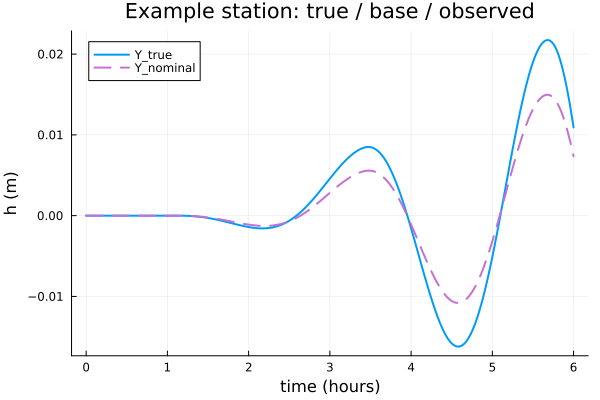

In [14]:
# Pick a station index 
s = station_idxs[end ÷ 2]  # center station
p = plot(times./3600, Y_true[:, s], label="Y_true", lw=2)
plot!(times./3600, Y_nominal[:, s], label="Y_nominal", lw=2, ls=:dash, color=cur_colors[4])
xlabel!("time (hours)"); ylabel!("h (m)"); title!("Example station: true / base / observed")

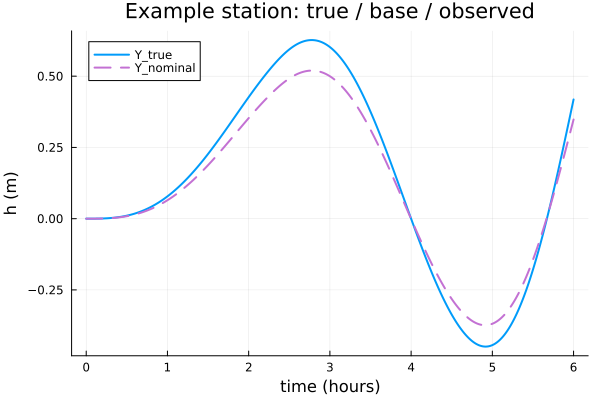

In [15]:
# Pick a station index 
s = station_idxs[end]  # last station
p = plot(times./3600, Y_true[:, s], label="Y_true", lw=2)
plot!(times./3600, Y_nominal[:, s], label="Y_nominal", lw=2, ls=:dash, color=cur_colors[4])
xlabel!("time (hours)"); ylabel!("h (m)"); title!("Example station: true / base / observed")

┌ Info: Saved animation to /Users/sara/Desktop/Deltares/Final Report Code/Model-2/gif/flat_true_simulation.gif
└ @ Plots /Users/sara/.julia/packages/Plots/ywg93/src/animation.jl:156


 13.282697 seconds (4.12 M allocations: 239.440 MiB, 2.07% gc time, 5.46% compilation time: 33% of which was recompilation)


Plots.AnimatedGif("/Users/sara/Desktop/Deltares/Final Report Code/Model-2/gif/flat_true_simulation.gif")
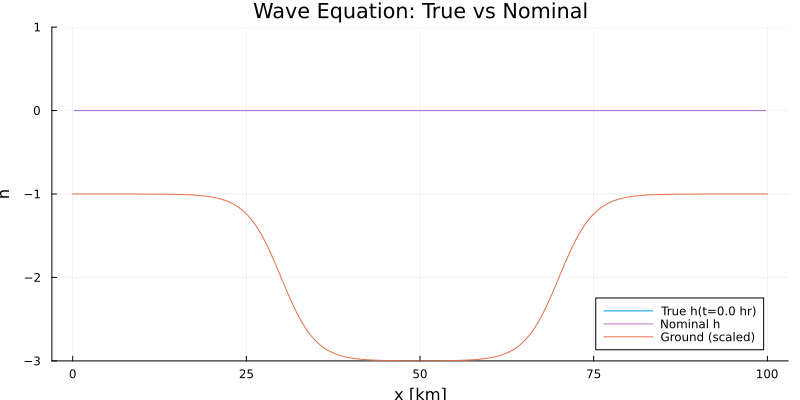

In [16]:
@time begin
    anim = @animate for i in 1:length(sol_true.t)
        p = plot(1e-3 * x_h, sol_true[i].h, label="True h(t=$(round(sol_true.t[i]/3600, digits=1)) hr)", xlabel="x [km]", ylabel="h", ylim=(-3, 1), lw=1, legend=:bottomright) 
        plot!(1e-3 * x_h, sol_nominal[i].h, label="Nominal h", color=cur_colors[4], lw=1)
        plot!(1e-3 * x_u, -0.1 * D, label="Ground (scaled)", lw=1, color=cur_colors[2])
        plot!(p, size=(800,400), title="Wave Equation: True vs Nominal")
    end
    gif(anim, "gif/$(init_state)_true_simulation.gif", fps=30)
end

##### More Time Series Visualization

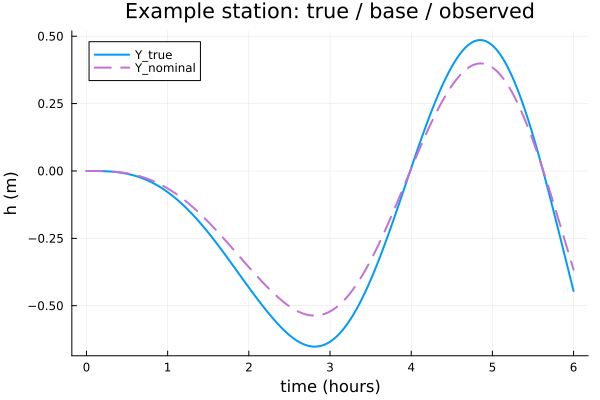

In [17]:
s = station_idxs[1]  # first station
p = plot(times./3600, Y_true[:, s], label="Y_true", lw=2)
plot!(times./3600, Y_nominal[:, s], label="Y_nominal", lw=2, ls=:dash, color=cur_colors[4])
xlabel!("time (hours)"); ylabel!("h (m)"); title!("Example station: true / base / observed")

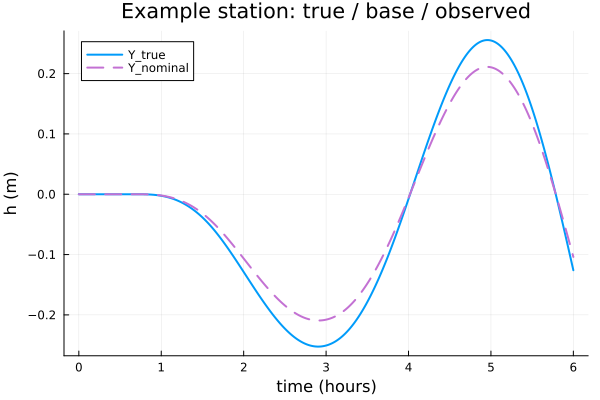

In [18]:
s = station_idxs[end ÷ 4] 
p = plot(times./3600, Y_true[:, s], label="Y_true", lw=2)
plot!(times./3600, Y_nominal[:, s], label="Y_nominal", lw=2, ls=:dash, color=cur_colors[4])
xlabel!("time (hours)"); ylabel!("h (m)"); title!("Example station: true / base / observed")

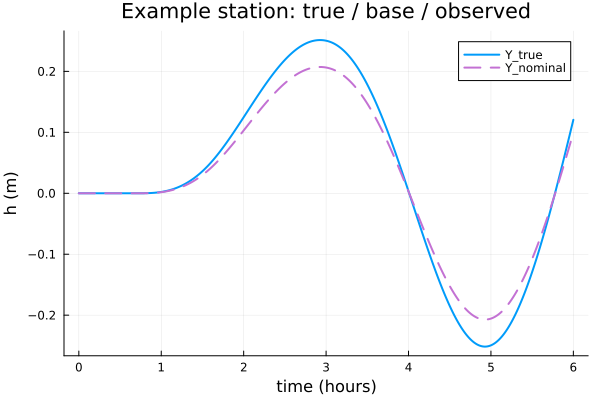

In [19]:
s = station_idxs[3 * end ÷ 4]  
p = plot(times./3600, Y_true[:, s], label="Y_true", lw=2)
plot!(times./3600, Y_nominal[:, s], label="Y_nominal", lw=2, ls=:dash, color=cur_colors[4])
xlabel!("time (hours)"); ylabel!("h (m)"); title!("Example station: true / base / observed")